In [ ]:

import math
import random
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from nflows.flows import Flow as NSF_Flow
from nflows.distributions import StandardNormal
from nflows.transforms import CompositeTransform, RandomPermutation
from nflows.transforms.coupling import PiecewiseRationalQuadraticCouplingTransform
from nflows.nn.nets import ResidualNet
from nflows.transforms.coupling import AffineCouplingTransform

#It needs to be updated later, it still produces different result each time
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## classes for the realNVP-GMM and neural spline flow-gmm

In [ ]:
#  toy SSL dataset
def make_circles_ssl(n_total=1000, n_labels_per_class=25, noise=0.05, factor=0.4):
    X, y = make_circles(n_samples=n_total, noise=noise, factor=factor)
    labels = -np.ones(n_total, dtype=int)
    for cls in [0, 1]:
        idxs = np.where(y == cls)[0]
        chosen = np.random.choice(idxs, size=n_labels_per_class, replace=False)
        labels[chosen] = cls
    return X.astype('float32'), labels

# prior
class SSLGaussMixture(nn.Module):
    def __init__(self, means: torch.Tensor, learn_pi: bool = False):
        super().__init__()
        self.register_parameter('means', nn.Parameter(means, requires_grad=False))
        self.K, self.D = means.shape

        if learn_pi:
            self.logits_pi = nn.Parameter(torch.zeros(self.K, device=means.device))
        else:
            self.register_buffer('logits_pi', torch.zeros(self.K, device=means.device))

    def _get_log_pi(self):
        return torch.log_softmax(self.logits_pi, dim=0)

    def log_prob(self, z):
        mus = self.means.unsqueeze(0)  # [1, K, D]
        zs  = z.unsqueeze(1)           # [B, 1, D]
        exp = -0.5 * ((zs - mus) ** 2).sum(-1)
        coef = -0.5 * self.D * math.log(2 * math.pi)
        log_comp = coef + exp
        log_pi = self._get_log_pi().unsqueeze(0)  # [1, K]
        return torch.logsumexp(log_pi + log_comp, dim=1)

    def posterior(self, z):
        mus = self.means.unsqueeze(0)
        zs  = z.unsqueeze(1)
        exp = -0.5 * ((zs - mus) ** 2).sum(-1)
        coef = -0.5 * self.D * math.log(2 * math.pi)
        log_comp = coef + exp
        log_pi = self._get_log_pi().unsqueeze(0)
        return torch.softmax(log_pi + log_comp, dim=1)

class FlowLoss:
    def __init__(self, prior): self.prior = prior
    def __call__(self, z, ladj, y):
        sup = (y >= 0)
        uns = (y < 0)
        loss = 0.0
        if uns.any():
            lp = self.prior.log_prob(z[uns])
            loss += -(lp + ladj[uns]).mean()
        if sup.any():
            post = self.prior.posterior(z[sup])
            ys = y[sup]
            loss += -torch.log(post[torch.arange(post.size(0)), ys]).mean()
        return loss

#  Neural Spline Flow 
class NeuralSplineTabular(nn.Module):
    def __init__(self, num_layers=5, in_dim=2, hidden=512, bins=8, tail=5.0):
        super().__init__()
        self.tail = tail
        transforms = []
        for i in range(num_layers):
            transforms.append(RandomPermutation(features=in_dim))
            mask = [(i + j) % 2 == 0 for j in range(in_dim)]
            transforms.append(
                PiecewiseRationalQuadraticCouplingTransform(
                    mask=mask,
                    transform_net_create_fn=lambda ic, oc: ResidualNet(
                        in_features=ic, out_features=oc,
                        hidden_features=hidden, num_blocks=2,
                        dropout_probability=0.0, use_batch_norm=False
                    ),
                    num_bins=bins, tail_bound=tail,
                    tails='linear', min_bin_width=1e-3
                )
            )
        self.transform = CompositeTransform(transforms)
        self.flow = NSF_Flow(transform=self.transform, distribution=StandardNormal([in_dim]))
        self._ladj = None

    def forward(self, x):
        z, ladj = self.transform.forward(x)
        self._ladj = ladj
        return z

    def logdet(self):
        return self._ladj
    

#  RealNVP Flow
class RealNVPTabular(nn.Module):
    def __init__(self, num_coupling_layers=5, in_dim=2, hidden=512):
        super().__init__()
        transforms = []
        for i in range(num_coupling_layers):
            transforms.append(RandomPermutation(features=in_dim))
            mask = [(i + j) % 2 == 0 for j in range(in_dim)]
            transforms.append(
                AffineCouplingTransform(
                    mask=mask,
                    transform_net_create_fn=lambda ic, oc: ResidualNet(
                        in_features=ic, out_features=oc,
                        hidden_features=hidden, num_blocks=2,
                        dropout_probability=0.0, use_batch_norm=False
                    )
                )
            )
        self.flow = NSF_Flow(
            transform=CompositeTransform(transforms),
            distribution=StandardNormal([in_dim])
        )

    def forward(self, x):
        z, ladj = self.flow._transform.forward(x)
        return z, ladj

    def sample(self, num):
        return self.flow.sample(num)



## Training for NSF

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X, labels = make_circles_ssl()
x = torch.from_numpy(X).to(device)
y = torch.from_numpy(labels).to(device)

means = torch.tensor([[3.5, 0.], [-3.5, 0.]], dtype=torch.float32).to(device)

prior = SSLGaussMixture(means, learn_pi=False).to(device)

flow = NeuralSplineTabular().to(device)
loss_fn = FlowLoss(prior)
opt = optim.Adam(list(flow.parameters()) + list(prior.parameters()), lr=1e-5, weight_decay=1e-2)

sup = (y >= 0)
x_sup, y_sup = x[sup], y[sup]
x_uns = x[~sup]
bs = x_sup.size(0)

for t in range(5001):
    idx = torch.randint(0, x_uns.size(0), (bs,), device=device)
    bx = torch.cat([x_uns[idx], x_sup], dim=0)
    by = torch.cat([-torch.ones(bs, dtype=torch.long, device=device), y_sup], dim=0)

    z = flow(bx)
    ladj = flow.logdet()
    loss = loss_fn(z, ladj, by)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if t % 50 == 0:
        print(f"Epoch {t:4d} — loss {loss.item():.4f}")
        if hasattr(prior, "logits_pi"):
            pi_vals = torch.softmax(prior.logits_pi, dim=0)
            #print(f"    learned pi: {pi_vals.detach().cpu().numpy()}")


Epoch    0 — loss 9.2540
Epoch   50 — loss 9.0580
Epoch  100 — loss 8.5007
Epoch  150 — loss 8.3116
Epoch  200 — loss 7.7824
Epoch  250 — loss 7.2001
Epoch  300 — loss 6.3208
Epoch  350 — loss 5.8496
Epoch  400 — loss 5.2255
Epoch  450 — loss 4.2056
Epoch  500 — loss 3.2960
Epoch  550 — loss 2.5129
Epoch  600 — loss 2.0642
Epoch  650 — loss 1.6921
Epoch  700 — loss 1.2656
Epoch  750 — loss 1.5352
Epoch  800 — loss 1.3105
Epoch  850 — loss 1.2816
Epoch  900 — loss 1.1467
Epoch  950 — loss 0.9870
Epoch 1000 — loss 0.9914
Epoch 1050 — loss 1.0688
Epoch 1100 — loss 1.3404
Epoch 1150 — loss 1.2437
Epoch 1200 — loss 1.1364
Epoch 1250 — loss 0.9095
Epoch 1300 — loss 1.2110
Epoch 1350 — loss 1.0210
Epoch 1400 — loss 1.0247
Epoch 1450 — loss 0.9199
Epoch 1500 — loss 0.9769
Epoch 1550 — loss 0.7136
Epoch 1600 — loss 0.9500
Epoch 1650 — loss 1.0709
Epoch 1700 — loss 1.0235
Epoch 1750 — loss 0.8008
Epoch 1800 — loss 0.9493
Epoch 1850 — loss 0.9259
Epoch 1900 — loss 0.8944
Epoch 1950 — loss 1.0173


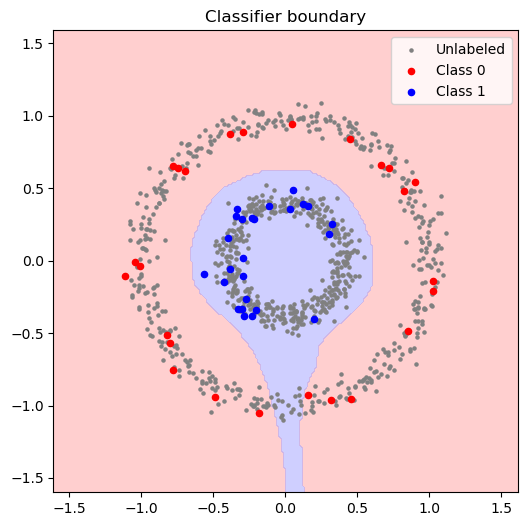

In [52]:
import matplotlib.pyplot as plt


flow_cpu = flow.to('cpu')
prior_cpu = SSLGaussMixture(means.cpu())

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xs = np.linspace(x_min, x_max, 200)
ys = np.linspace(y_min, y_max, 200)
xx_x, yy_x = np.meshgrid(xs, ys)


pts = torch.from_numpy(np.stack([xx_x.ravel(), yy_x.ravel()], 1).astype('float32'))


with torch.no_grad():
    z_pts = flow_cpu(pts)
    preds = prior_cpu.posterior(z_pts).argmax(dim=1).numpy().reshape(xx_x.shape)


plt.figure(figsize=(6, 6))
plt.contourf(xx_x, yy_x, preds, levels=[-0.5, 0.5, 1.5], colors=['#FFA0A0', '#A0A0FF'], alpha=0.5)


mask_l = labels >= 0
plt.scatter(X[~mask_l, 0], X[~mask_l, 1], c='gray', s=5, label='Unlabeled')
plt.scatter(X[labels == 0, 0], X[labels == 0, 1], c='red', s=20, label='Class 0')
plt.scatter(X[labels == 1, 0], X[labels == 1, 1], c='blue', s=20, label='Class 1')

plt.title('Classifier boundary')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
plt.show()

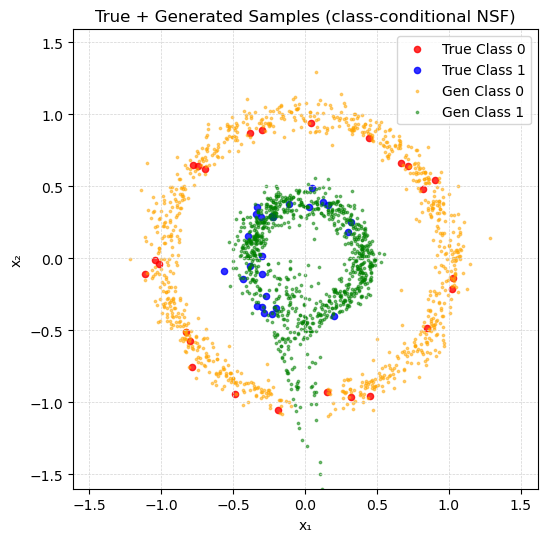

In [72]:




x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

n_per_class = 1000
Xs, Ys = [], []
with torch.no_grad():
    for k in range(prior_cpu.K):
        mu_k = prior_cpu.means[k]                
        z_k  = mu_k.unsqueeze(0) + torch.randn(n_per_class, 2)
        x_k, _ = flow_cpu.transform.inverse(z_k)   
        Xs.append(x_k.cpu().numpy())
        Ys.append(np.full(n_per_class, k, dtype=int))

x_gen = np.vstack(Xs)     
y_gen = np.concatenate(Ys)

# 3) Plot
plt.figure(figsize=(6,6))


mask_unl = (labels < 0)

plt.scatter(X[labels==0,0], X[labels==0,1], c='red',
            s=20, label='True Class 0', alpha=0.8)
plt.scatter(X[labels==1,0], X[labels==1,1], c='blue',
            s=20, label='True Class 1', alpha=0.8)


plt.scatter(x_gen[y_gen==0,0], x_gen[y_gen==0,1], c='orange',
            s=3, label='Gen Class 0', alpha=0.5)
plt.scatter(x_gen[y_gen==1,0], x_gen[y_gen==1,1], c='green',
            s=3, label='Gen Class 1', alpha=0.5)

plt.legend()
plt.title('True + Generated Samples (class‐conditional NSF)')
plt.xlabel('x₁')
plt.ylabel('x₂')


plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.gca().set_aspect('equal', 'box')
plt.grid(which='both', linestyle='--', color='lightgray', linewidth=0.5)

plt.show()


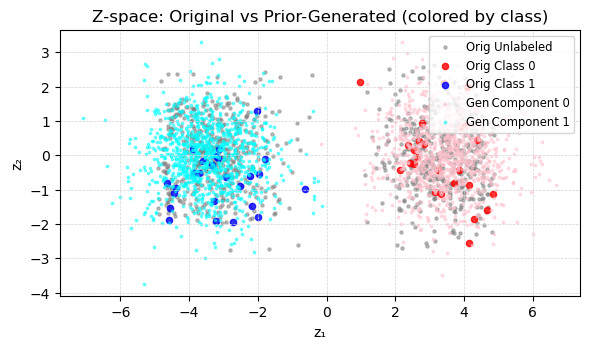

In [66]:


with torch.no_grad():
    Z_orig = flow_cpu(torch.from_numpy(X.astype('float32'))) 
Z_orig = Z_orig.numpy()


n_per_comp = 1000
Z_gen = []
y_gen = []
for k in range(prior_cpu.K):
    mu_k = prior_cpu.means[k]               
    zs   = mu_k.unsqueeze(0) + torch.randn(n_per_comp, 2)
    Z_gen.append(zs.cpu().numpy())
    y_gen.append(np.full(n_per_comp, k, dtype=int))
Z_gen = np.vstack(Z_gen)  
y_gen = np.concatenate(y_gen) 


plt.figure(figsize=(6,6))


mask_unl = (labels < 0)
plt.scatter(Z_orig[mask_unl,0], Z_orig[mask_unl,1],
            c='gray',   s=5, alpha=0.5, label='Orig Unlabeled')
plt.scatter(Z_orig[labels==0,0], Z_orig[labels==0,1],
            c='red',    s=20, alpha=0.8, label='Orig Class 0')
plt.scatter(Z_orig[labels==1,0], Z_orig[labels==1,1],
            c='blue',   s=20, alpha=0.8, label='Orig Class 1')


plt.scatter(Z_gen[y_gen==0,0], Z_gen[y_gen==0,1],
            c='pink',   s=3, alpha=0.5, label='Gen Component 0')
plt.scatter(Z_gen[y_gen==1,0], Z_gen[y_gen==1,1],
            c='cyan',   s=3, alpha=0.5, label='Gen Component 1')

plt.title('Z-space: Original vs Prior-Generated (colored by class)')
plt.xlabel('z₁')
plt.ylabel('z₂')
plt.legend(loc='upper right', fontsize='small')


ax = plt.gca()
ax.set_aspect('equal', 'box')
ax.grid(True, linestyle='--', color='lightgray', linewidth=0.5)

plt.tight_layout()
plt.show()


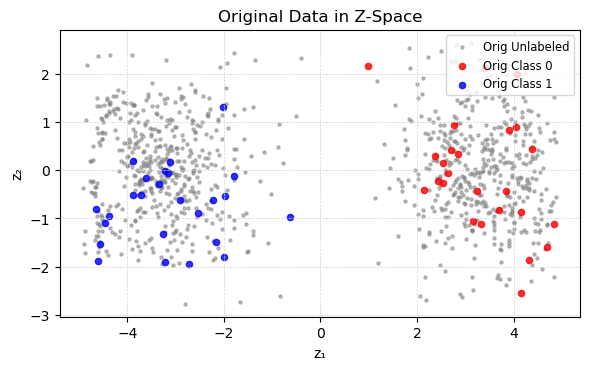

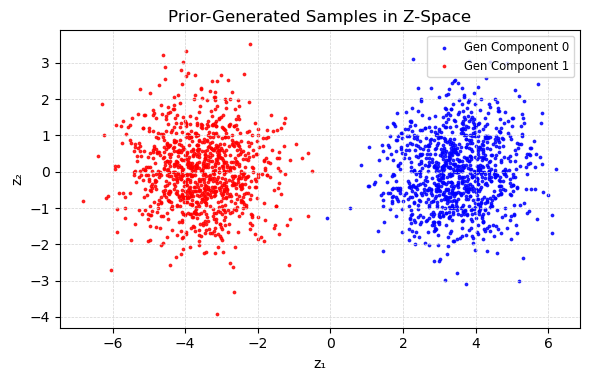

In [71]:



with torch.no_grad():
    Z_orig = flow_cpu(torch.from_numpy(X.astype('float32')))  
Z_orig = Z_orig.numpy()


n_per_comp = 1000
Z_gen = []
y_gen = []
for k in range(prior_cpu.K):
    mu_k = prior_cpu.means[k]              
    zs   = mu_k.unsqueeze(0) + torch.randn(n_per_comp, mu_k.shape[0])
    Z_gen.append(zs.cpu().numpy())
    y_gen.append(np.full(n_per_comp, k, dtype=int))
Z_gen = np.vstack(Z_gen)  
y_gen = np.concatenate(y_gen)


plt.figure(figsize=(6,6))
mask_unl = (labels < 0)
plt.scatter(Z_orig[mask_unl,0], Z_orig[mask_unl,1],
            c='gray',   s=5, alpha=0.5, label='Orig Unlabeled')
plt.scatter(Z_orig[labels==0,0], Z_orig[labels==0,1],
            c='red',    s=20, alpha=0.8, label='Orig Class 0')
plt.scatter(Z_orig[labels==1,0], Z_orig[labels==1,1],
            c='blue',   s=20, alpha=0.8, label='Orig Class 1')
plt.title('Original Data in Z-Space')
plt.xlabel('z₁'); plt.ylabel('z₂')
plt.legend(loc='upper right', fontsize='small')
ax = plt.gca()
ax.set_aspect('equal', 'box')
ax.grid(True, linestyle='--', color='lightgray', linewidth=0.5)
plt.tight_layout()


plt.figure(figsize=(6,6))
plt.scatter(Z_gen[y_gen==0,0], Z_gen[y_gen==0,1],
            c='blue',   s=3, alpha=0.8, label='Gen Component 0')
plt.scatter(Z_gen[y_gen==1,0], Z_gen[y_gen==1,1],
            c='red',   s=3, alpha=0.8, label='Gen Component 1')
plt.title('Prior-Generated Samples in Z-Space')
plt.xlabel('z₁'); plt.ylabel('z₂')
plt.legend(loc='upper right', fontsize='small')
ax = plt.gca()
ax.set_aspect('equal', 'box')
ax.grid(True, linestyle='--', color='lightgray', linewidth=0.5)
plt.tight_layout()



## Training RealVNP-GMM

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


X, labels = make_circles_ssl()
X_t = torch.from_numpy(X).to(device)
y_t = torch.from_numpy(labels).to(device)
lidx = (labels != -1)
X_lab, y_lab = X_t[lidx], y_t[lidx]
X_ul, y_ul   = X_t[~lidx], y_t[~lidx]
n_lab, n_ul  = len(y_lab), len(y_ul)


flow = RealNVPTabular(num_coupling_layers=5, in_dim=2, hidden=512).to(device)
means = torch.tensor([[3.5,0.],[ -3.5,0.]], dtype=torch.float32).to(device)
prior = SSLGaussMixture(means, learn_pi=False).to(device)

loss_fn = FlowLoss(prior)
opt = optim.Adam(list(flow.parameters()) + list(prior.parameters()),
                 lr=1e-5, weight_decay=1e-2) 

for t in range(5001):
    idx = torch.randperm(n_ul)[:n_lab]
    bx = torch.cat([X_ul[idx], X_lab], dim=0)
    by = torch.cat([y_ul[idx], y_lab], dim=0)

    z, ladj = flow(bx)
    loss    = loss_fn(z, ladj, by)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if t % 500 == 0:
        print(f"Epoch {t:4d} — loss {loss:.4f}")
        

Epoch    0 — loss 9.7248
Epoch  500 — loss 2.9917
Epoch 1000 — loss 2.8305
Epoch 1500 — loss 2.7992
Epoch 2000 — loss 2.9359
Epoch 2500 — loss 2.7755
Epoch 3000 — loss 2.7121
Epoch 3500 — loss 2.7095
Epoch 4000 — loss 2.7284
Epoch 4500 — loss 2.7125
Epoch 5000 — loss 2.7408


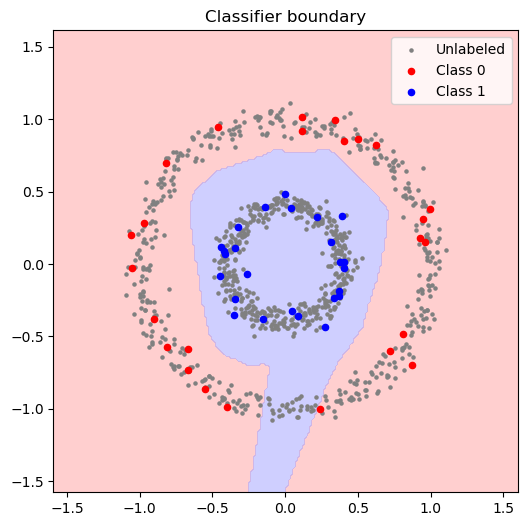

In [63]:


flow_cpu  = flow.to('cpu')
prior_cpu = SSLGaussMixture(means.cpu(), learn_pi=False)


x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
xs = np.linspace(x_min, x_max, 200)
ys = np.linspace(y_min, y_max, 200)
xx, yy = np.meshgrid(xs, ys)

pts = torch.from_numpy(
    np.stack([xx.ravel(), yy.ravel()], axis=1).astype('float32')
)


with torch.no_grad():

    z_pts, _ = flow_cpu(pts)

    post = prior_cpu.posterior(z_pts)

    preds = post.argmax(dim=1).numpy().reshape(xx.shape)


plt.figure(figsize=(6,6))
plt.contourf(
    xx, yy, preds,
    levels=[-0.5, 0.5, 1.5],
    colors=['#FFA0A0','#A0A0FF'],
    alpha=0.5
)

mask_l = labels >= 0
plt.scatter(
    X[~mask_l,0], X[~mask_l,1],
    c='gray', s=5, label='Unlabeled'
)
plt.scatter(
    X[labels==0,0], X[labels==0,1],
    c='red', s=20, label='Class 0'
)
plt.scatter(
    X[labels==1,0], X[labels==1,1],
    c='blue', s=20, label='Class 1'
)
plt.title('Classifier boundary')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
plt.show()


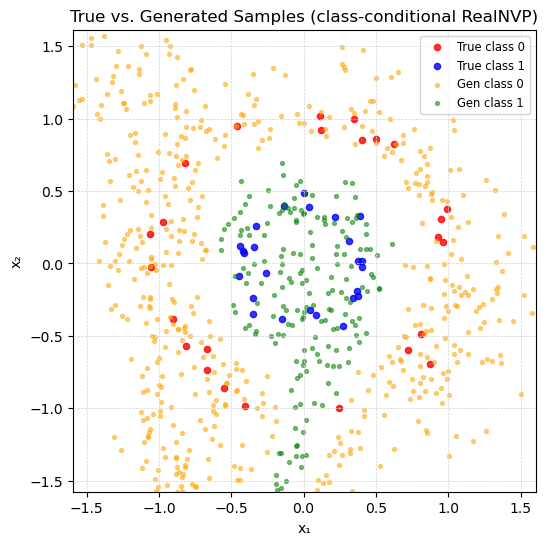

In [43]:


n_per_class = 1000
Xs, Ys = [], []
with torch.no_grad():
    for k in range(prior_cpu.K):
        μk = prior_cpu.means[k]                 
        zk = μk.unsqueeze(0) + torch.randn(n_per_class, 2)
        xk, _ = flow_cpu.flow._transform.inverse(zk)   
        Xs.append(xk.numpy())
        Ys.append(np.full(n_per_class, k, dtype=int))

X_gen = np.vstack(Xs)        
y_gen = np.concatenate(Ys)


plt.figure(figsize=(6,6))

plt.scatter(X[labels==0,0], X[labels==0,1], c='red',   s=20, label='True class 0', alpha=0.8)
plt.scatter(X[labels==1,0], X[labels==1,1], c='blue',  s=20, label='True class 1', alpha=0.8)

plt.scatter(X_gen[y_gen==0,0], X_gen[y_gen==0,1], c='orange', s=8, label='Gen class 0', alpha=0.5)
plt.scatter(X_gen[y_gen==1,0], X_gen[y_gen==1,1], c='green',  s=8, label='Gen class 1', alpha=0.5)

plt.legend(loc='upper right', fontsize='small')
plt.title('True vs. Generated Samples (class‐conditional RealNVP)')
plt.xlabel('x₁'); plt.ylabel('x₂')
plt.xlim(x_min, x_max); plt.ylim(y_min, y_max)
plt.gca().set_aspect('equal', 'box')
plt.grid(True, linestyle='--', color='lightgray', linewidth=0.5)
plt.show()



with torch.no_grad():
    Z_orig, _ = flow_cpu( torch.from_numpy(X.astype('float32')) )
Z_orig = Z_orig.numpy()

Zs, Ys = [], []
for k in range(prior_cpu.K):
    μk = prior_cpu.means[k]
    zk = μk.unsqueeze(0) + torch.randn(n_per_class, 2)
    Zs.append(zk.numpy())
    Ys.append(np.full(n_per_class, k, dtype=int))
Z_gen = np.vstack(Zs)
y_gen = np.concatenate(Ys)

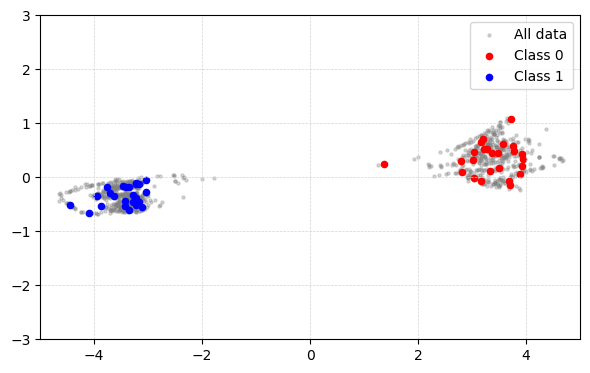

In [61]:


x_min, x_max = -5, 5
y_min, y_max = -3, 3

plt.figure(figsize=(6,6))
plt.scatter(Z_orig[:,0], Z_orig[:,1], c='gray', s=5, alpha=0.3, label='All data')
plt.scatter(Z_orig[labels==0,0], Z_orig[labels==0,1], c='red',  s=20, label='Class 0')
plt.scatter(Z_orig[labels==1,0], Z_orig[labels==1,1], c='blue', s=20, label='Class 1')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')  # **this**

plt.legend()
plt.grid(True, linestyle='--', color='lightgray', linewidth=0.5)
plt.tight_layout()
plt.show()


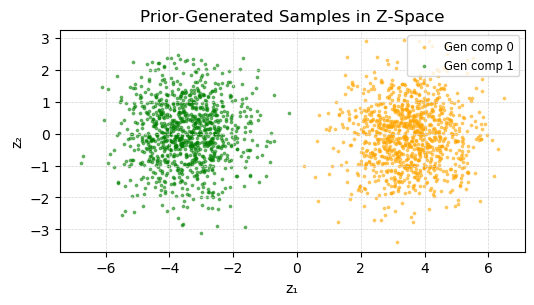

In [45]:

plt.figure(figsize=(6,6))
plt.scatter(Z_gen[y_gen==0,0], Z_gen[y_gen==0,1], c='orange', s=3, label='Gen comp 0', alpha=0.5)
plt.scatter(Z_gen[y_gen==1,0], Z_gen[y_gen==1,1], c='green',  s=3, label='Gen comp 1', alpha=0.5)
plt.title('Prior‐Generated Samples in Z‐Space')
plt.xlabel('z₁'); plt.ylabel('z₂')
plt.legend(loc='upper right', fontsize='small')
plt.gca().set_aspect('equal', 'box')
plt.grid(True, linestyle='--', color='lightgray', linewidth=0.5)
plt.show()